#### Unsupervised machine learning using the K-means clustering algorithm.

In [1]:
# import necessasry libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm


%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

##### Exploratory data analysis

In [2]:
# import the dataset
df = pd.read_csv("Mall_Customers.csv")

df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.shape

(200, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


###### We have 0 null values.
##### Variables description:
###### CustomerID: Unique customer identifier.
###### Gender: Customer gender.
###### Age: Customer age.
###### Annual Income (k$): Customer's annual income in k$.
###### CSpending Score (1-100): A score assigned to each customer that reflects their level of spending.

##### Summary descriptive statistics of the numerical variables

In [5]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


##### Taking a closer look at the categorical variable 'Gender'

In [6]:
# Count the different values (category names)
df.Genre.value_counts()

Genre
Female    112
Male       88
Name: count, dtype: int64

In [7]:
# Rename the features to convenient ones
df.rename(columns={'Genre':'Gender', 'Annual Income (k$)':'Annual_Income', 'Spending Score (1-100)':'Spending_Score'}, inplace=True) 

# Remove CustomerID as it's not relevant for our study.
# Create a backup copy of the dataframe before removing the CustomerID.
df_backup = df.copy()
df.drop(columns = 'CustomerID', inplace = True)


df.head()

,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


##### Checking for outliers

##### What is the Outlier Formula?
The outlier formula, also known as the 1.5 IQR rule, is a rule of thumb used for identifying outliers. Outliers are extreme values that lie far from the other values in the data set.

The outlier formula designates outliers based on an upper and lower boundary (you can think of these as cutoff points). Any value that is 1.5 x IQR greater than the third quartile is designated as an outlier and any value that is 1.5 x IQR less than the first quartile is also designated as an outlier.

![Alt text](outliers_formula.svg)



In [8]:
# The function receives a dataframe and a column name and returns the quartiles.
def get_iqr_values(df_in, col_name):
    median_value = df_in[col_name].median() # The median.
    q1 = df_in[col_name].quantile(0.25) # The 1st quartile.
    q3 = df_in[col_name].quantile(0.75) # The 3rd quartile.
    iqr = q3-q1 # The interquartile range.
    lower_bound = q1 - 1.5*iqr # The minimum (marked |- in the boxplot).
    upper_bound = q3 + 1.5*iqr # The maximum (marked -| in the boxplot).
    return median_value, q1, q3, iqr, lower_bound, upper_bound

# The function receives a dataframe and the name of the column and returns the text formatted with the data from the get_iqr_values function.
def get_iqr_text(df_in, col_name):
    median_value, q1, q3, iqr, lower_bound, upper_bound = get_iqr_values(df_in, col_name)
    text = f"median={median_value:.2f}, q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}, lower_bound={lower_bound:.2f}, upper_bound={upper_bound:.2f}"
    return text

# The function receives a dataframe and the column name and returns the dataframe without the outliers.
def remove_outliers(df_in, col_name):
    _, _, _, _, lower_bound, upper_bound = get_iqr_values(df_in, col_name)
    df_out = df_in.loc[(df_in[col_name] > lower_bound) & (df_in[col_name] < upper_bound)]
    return df_out

# The function receives a dataframe and the name of the column and returns the number of outliers in the column.
def count_outliers(df_in, col_name):
    _, _, _, _, lower_bound, upper_bound = get_iqr_values(df_in, col_name)
    df_outliers = df_in.loc[(df_in[col_name] <= lower_bound) | (df_in[col_name] >= upper_bound)]
    return df_outliers.shape[0]

# The function receives the name of a dataframe and the name of a column and plots a boxplot.
def boxplot(df_in, col_name):
    title = get_iqr_text(df_in, col_name)
    sns.boxplot(df_in[col_name], orient = 'h', color="mediumslateblue")
    plt.title(title)
    plt.show()
    
# The function receives a dataframe and iterates through each of the numeric columns to remove all outliers or up to a maximum of 
# 100 iterations, returns the dataframe without the outliers, and displays the number of outliers removed.
def remove_all_outliers(df_in):
    columns=df.select_dtypes(include=['float64','int64']).columns
    totalOutliers=0
    for col_name in columns:
        iterations = 0
        outlier_count = count_outliers(df_in, col_name)
        
        while outlier_count > 0:
            iterations += 1

            if (iterations > 100):
                print("Number of outliers > 100. Breaking out of the loop")
                break  
            
            totalOutliers += count_outliers(df_in, col_name)
            df_in = remove_outliers(df_in, col_name)
            outlier_count = count_outliers(df_in, col_name)  
            
    print(totalOutliers, "Outliers removed",)
    return df_in



Age has 0 outliers


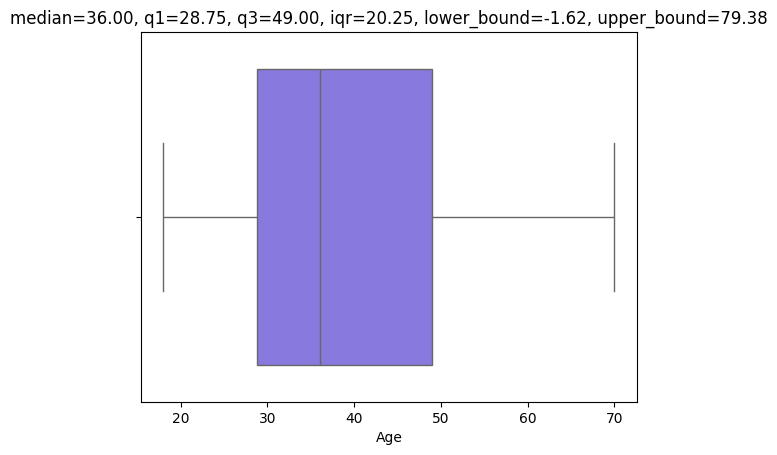

Annual_Income has 2 outliers


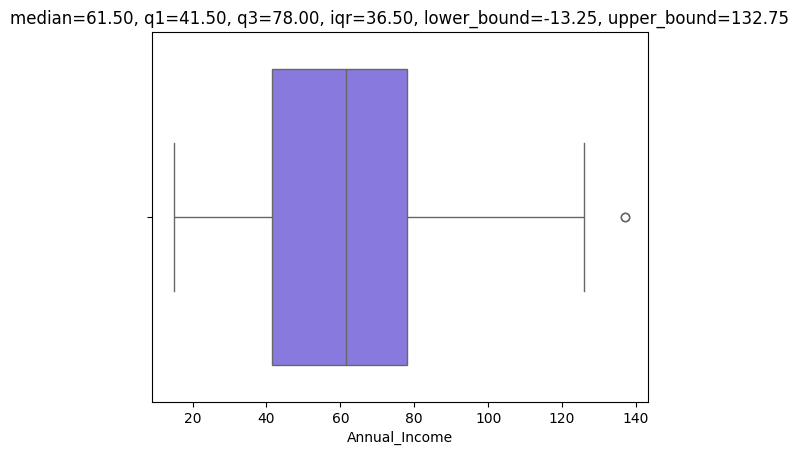

Spending_Score has 0 outliers


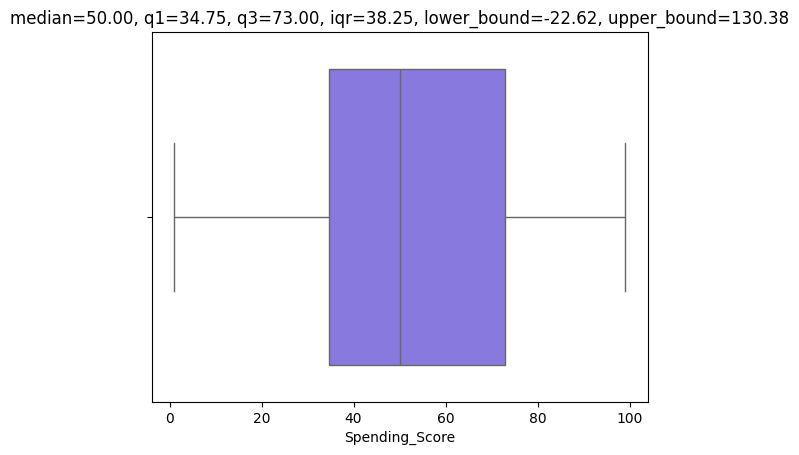

In [9]:
# Iterate through the numeric columns of the dataset to plot the outliers and describe the distribution of the variables.
for column in (df.select_dtypes(include=['float64','int64']).columns):
    print(f"{column} has {count_outliers(df, column)} outliers")
    boxplot(df, column)


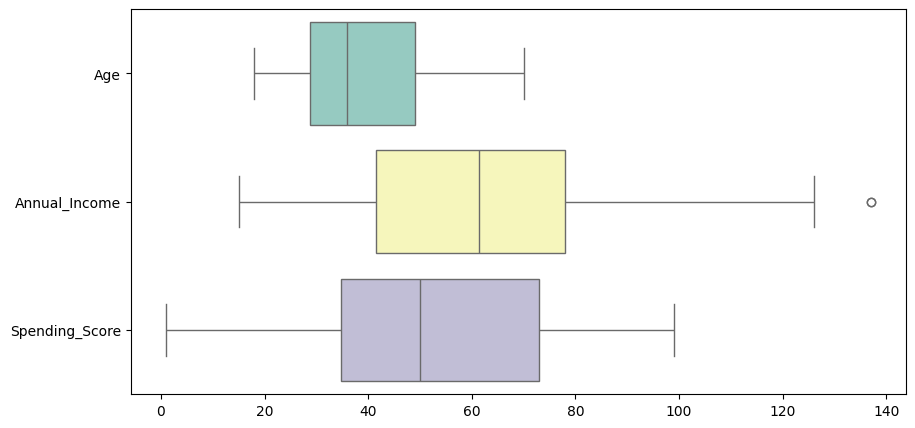

In [10]:
# Putting all the boxplots together
plt.figure(figsize = (10,5))
sns.boxplot(data = df, orient="h", palette="Set3")

plt.show()

In [11]:
df = remove_all_outliers(df)

2 Outliers removed


As we had only 2 outliers in our dataset (from the annual income), the best approach was to eliminate these extreme values.

#### Univariate analysis

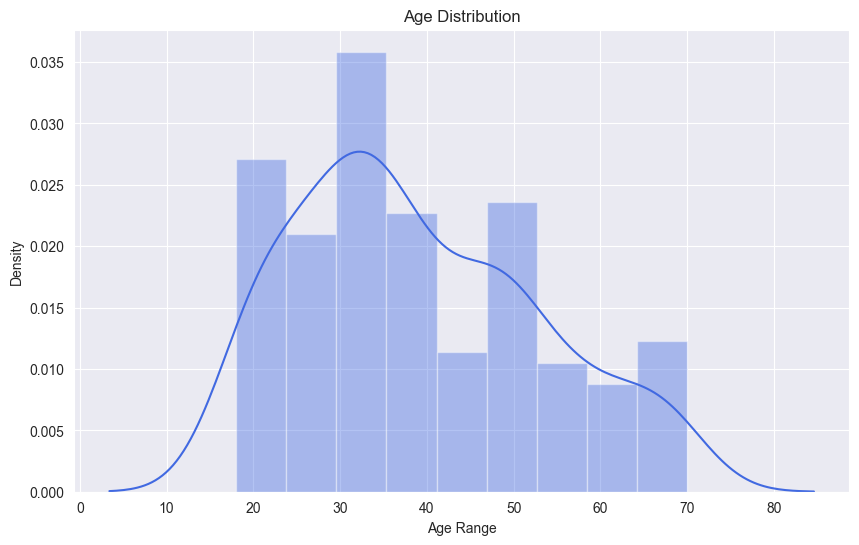

In [12]:
# Checking Age Distribution

plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

sns.histplot(df["Age"], kde=True,
            stat="density", kde_kws=dict(cut=3),
            alpha=.4, edgecolor=(1, 1, 1, .4),
            color="royalblue")
plt.title("Age Distribution")
plt.xlabel("Age Range")
plt.ylabel("Density")

plt.show()

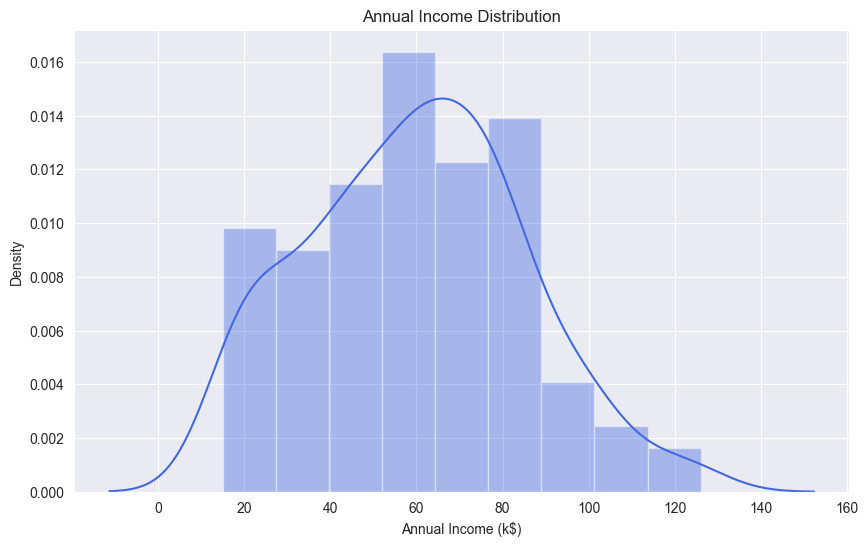

In [13]:
# Annual Income (k$) Distribution

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.histplot(df["Annual_Income"],  kde=True,
            stat="density", kde_kws=dict(cut=3),
            alpha=.4, edgecolor=(1, 1, 1, .4),
            color="royalblue")
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Density")
plt.show()


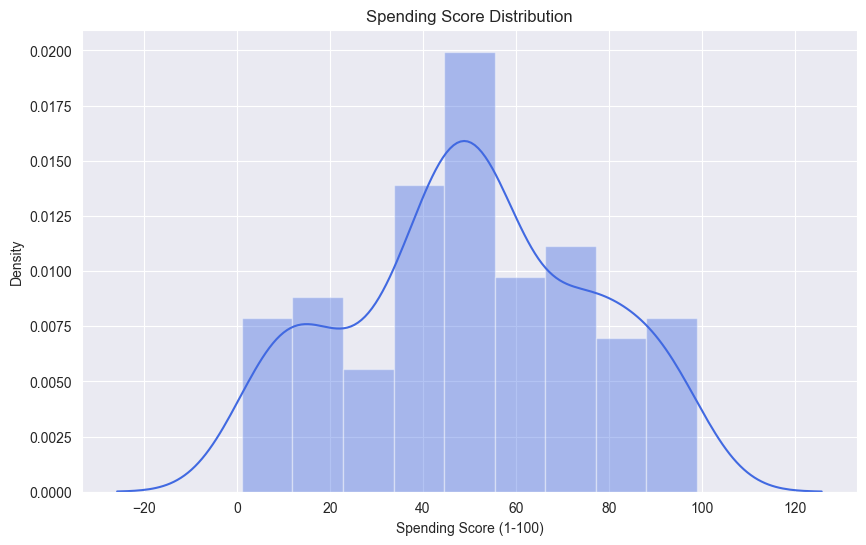

In [14]:
# Spending Score Distribution

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.histplot(df["Spending_Score"], kde=True,
            stat="density", kde_kws=dict(cut=3),
            alpha=.4, edgecolor=(1, 1, 1, .4),
            color="royalblue")
plt.title("Spending Score Distribution")
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Density")
plt.show()

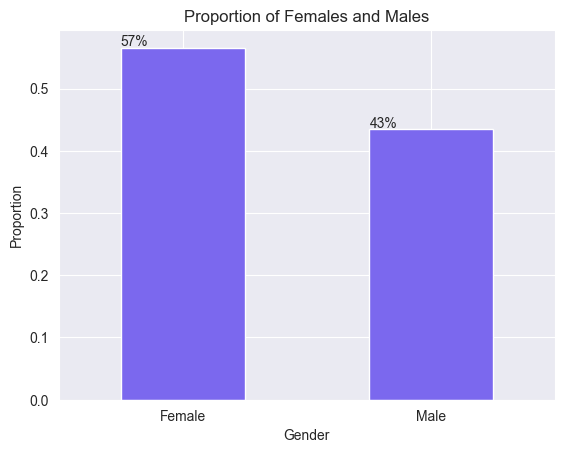

In [15]:
gender_plot=df.Gender.value_counts(normalize=True).plot.bar(ylabel='Proportion', title='Proportion of Females and Males', rot =0, color= "mediumslateblue")
plt.ticklabel_format(style="plain", axis="y")
for p in gender_plot.patches:
    gender_plot.annotate(str(round(p.get_height()*100))+'%', (p.get_x() * 1.005, p.get_height() * 1.005))

##### Bivariate Analysis

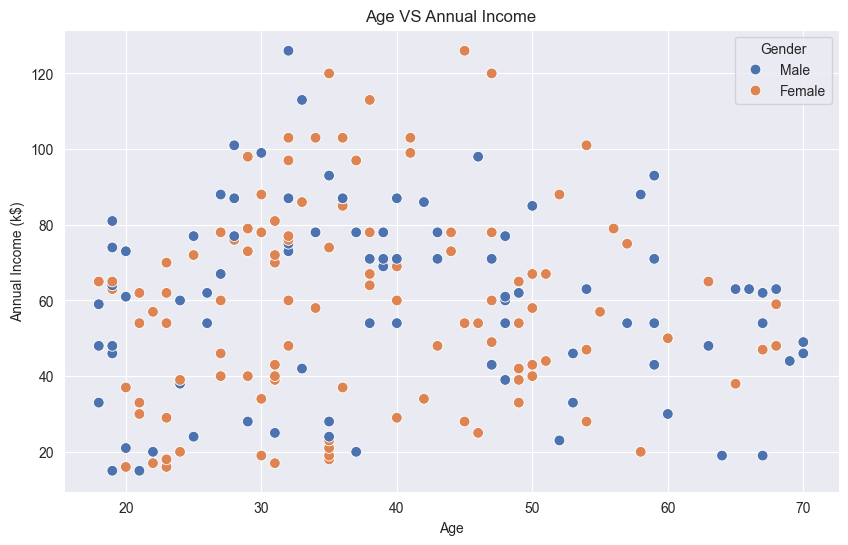

In [16]:
# Age VS Anual Income

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.scatterplot(data=df, x="Age", y= "Annual_Income", hue="Gender", s=60, palette="deep")
plt.title("Age VS Annual Income")
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
plt.show()

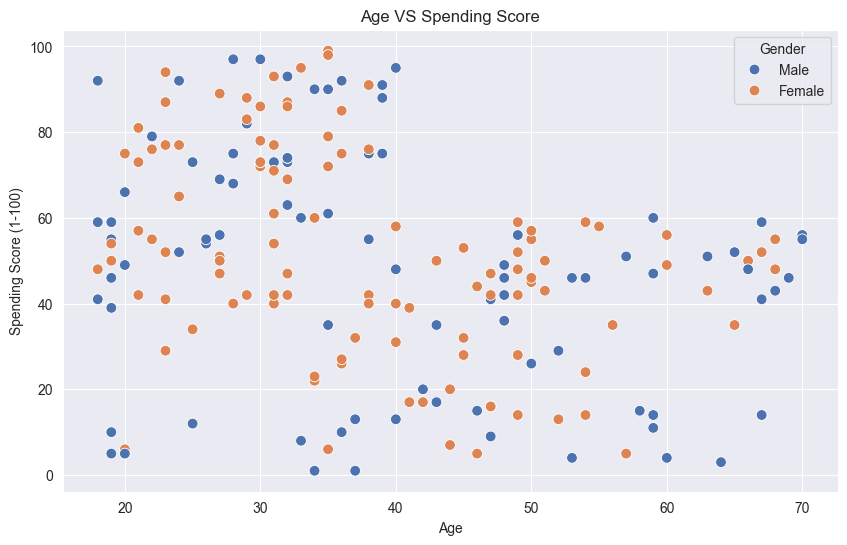

In [17]:
# Age VS Spending Score

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.scatterplot(data=df, x="Age", y= "Spending_Score", hue="Gender", s=60, palette="deep")
plt.title("Age VS Spending Score")
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")
plt.show()

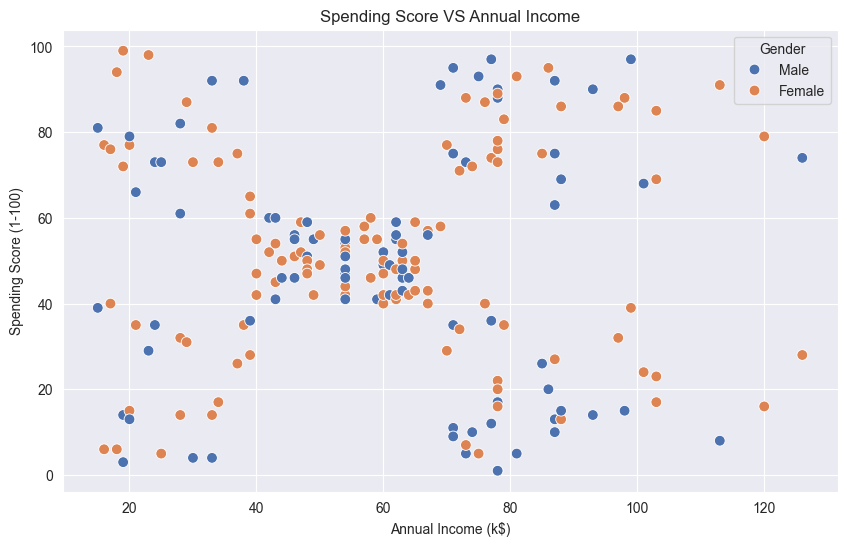

In [18]:
# Spending Score VS Anual Income

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.scatterplot(data=df, x="Annual_Income", y= "Spending_Score", hue="Gender", s=60, palette="deep")
plt.title("Spending Score VS Annual Income")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

##### Correlation Analysis

In [19]:
enc=OneHotEncoder() #Instantiate the object
#Create the columns with their respective name, and with the fit transform I assign a value of 1 or 0, and pass it to 
#an array to create the new dataframe
aux=pd.DataFrame(enc.fit_transform(df[['Gender']]).toarray(), columns=['F', 'M'])  
df=df.join(aux)
df=df.drop(['Gender'], axis=1)

<Axes: >

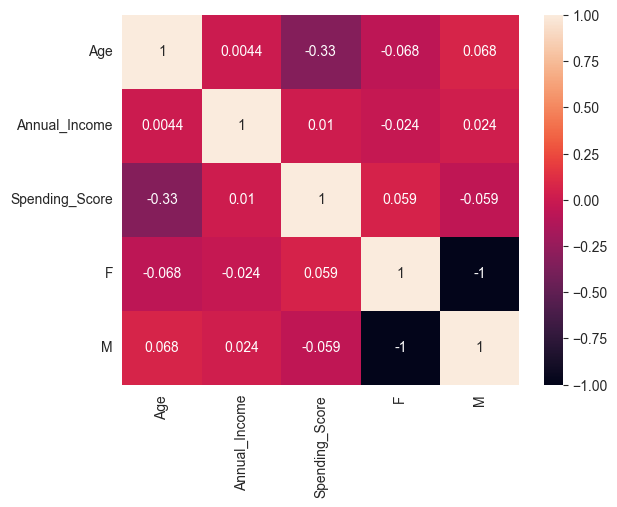

In [20]:
sns.heatmap(df.corr(),
           annot=True)

##### Unsupervised learning models

##### Segmentattion using the K-means algorithm

In [21]:
# Select the 2 variiables we're interested into
df_2=df[['Annual_Income','Spending_Score']]

In [22]:
# Perform a variable scaling by using the MinMaxScaler method (coding the variables between 0 and 1)
scaler = MinMaxScaler()
values_scaler = pd.DataFrame(scaler.fit_transform(df_2))

# Scale each variable in the dataset
index = -1
for columns in df_2:
    index += 1
    df_2[columns] = values_scaler[index]


# Defining the X values to use for the model training
X = df_2[['Annual_Income','Spending_Score']].values

/var/folders/9d/cjdzxf6s26gcn79xr19hz98h0000gn/T/ipykernel_46955/2386508374.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2[columns] = values_scaler[index]


##### Finding the hyperparameter K using the silhouette score method

For n_clusters = 2 The average silhouette_score is : 0.3191635851171418
For n_clusters = 3 The average silhouette_score is : 0.44871887330678173
For n_clusters = 4 The average silhouette_score is : 0.49991625710983445
For n_clusters = 5 The average silhouette_score is : 0.4234326758550015
For n_clusters = 6 The average silhouette_score is : 0.5253617364359031


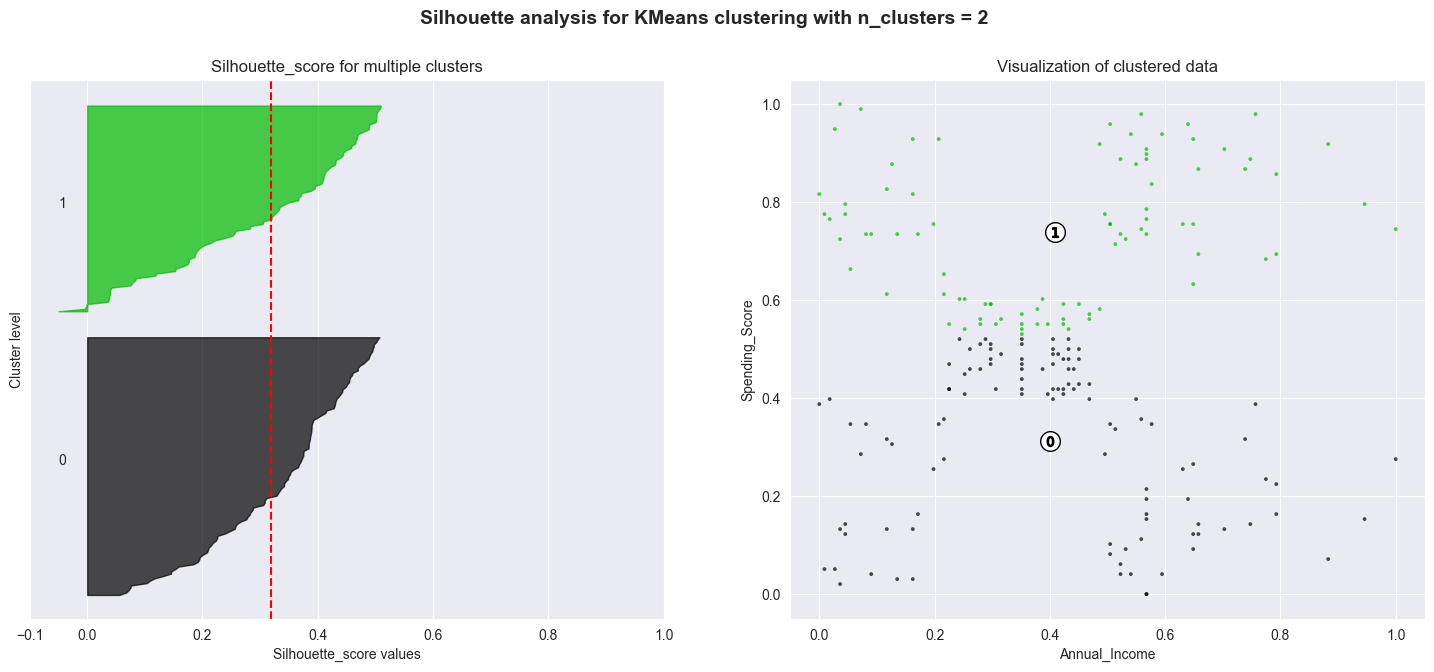

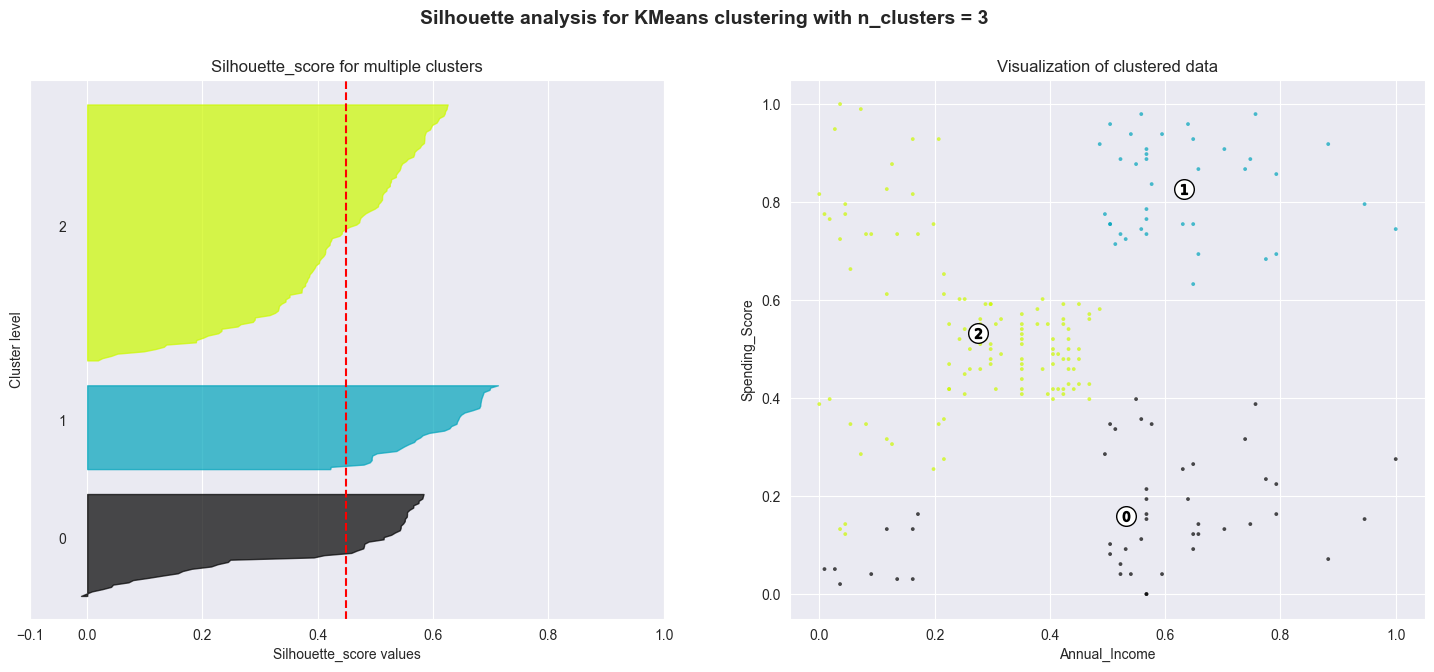

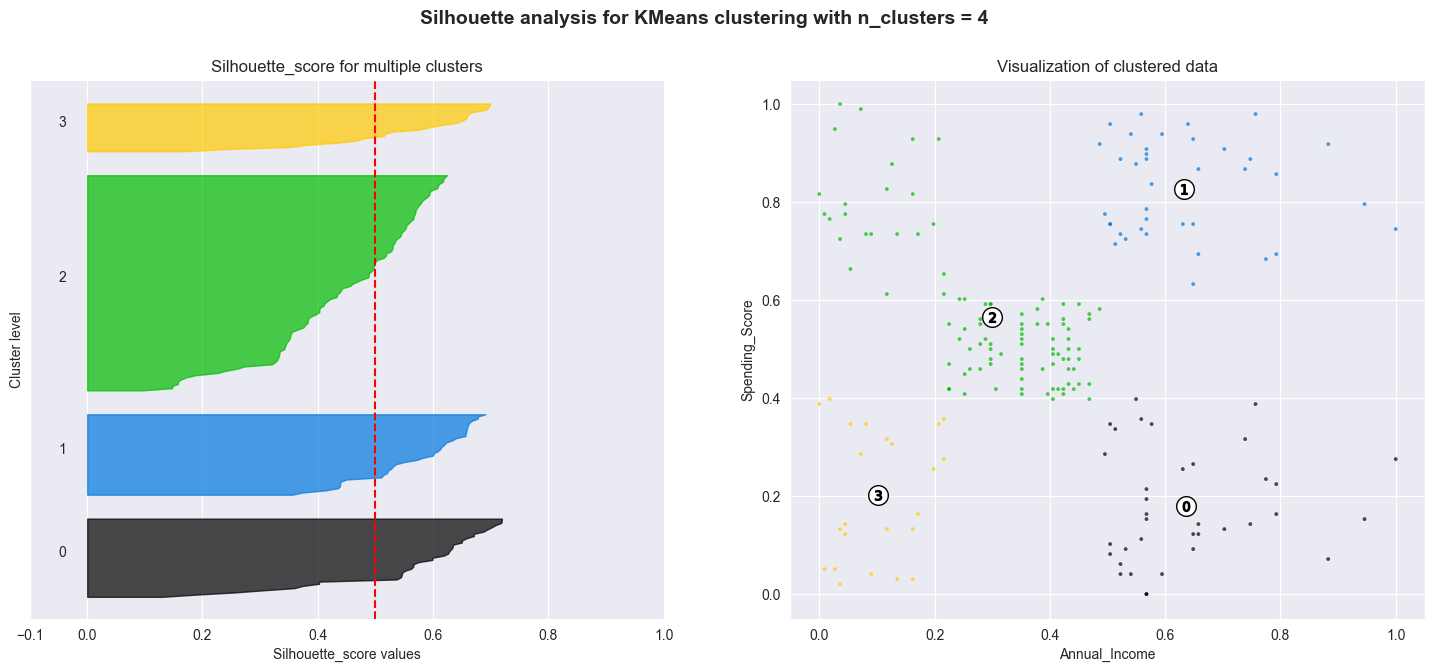

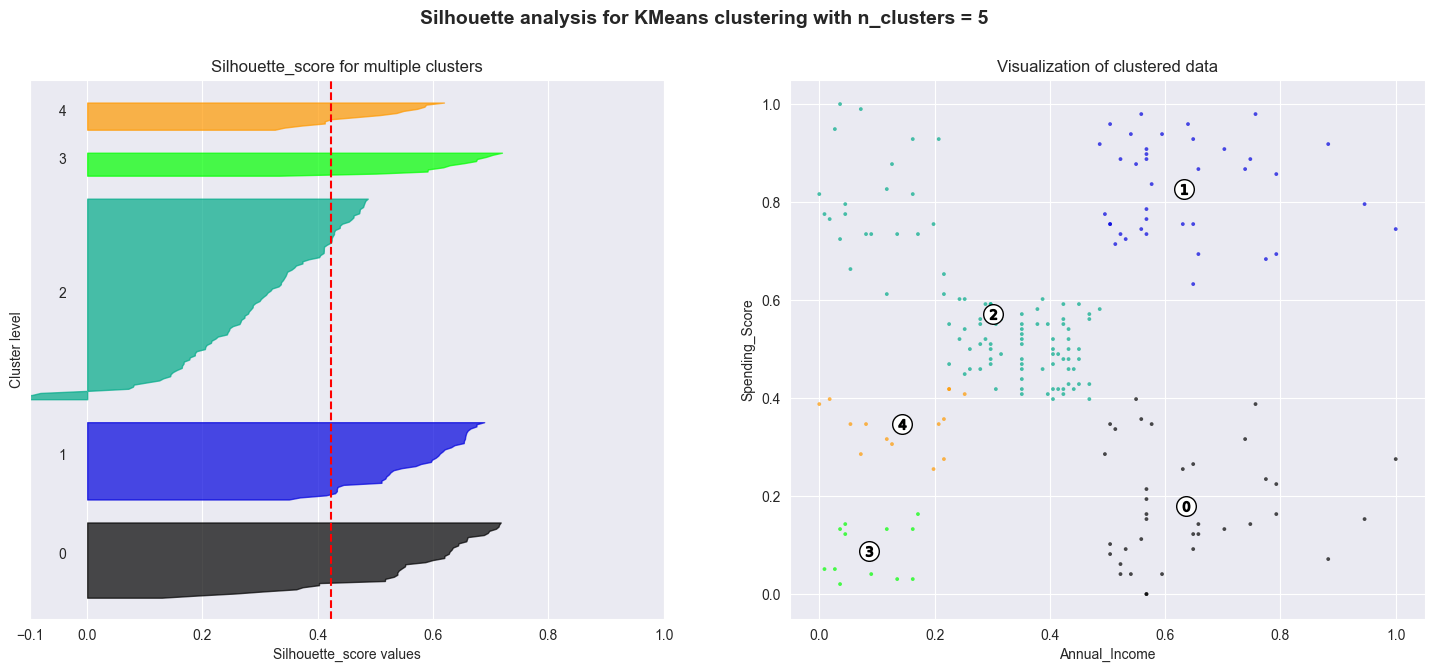

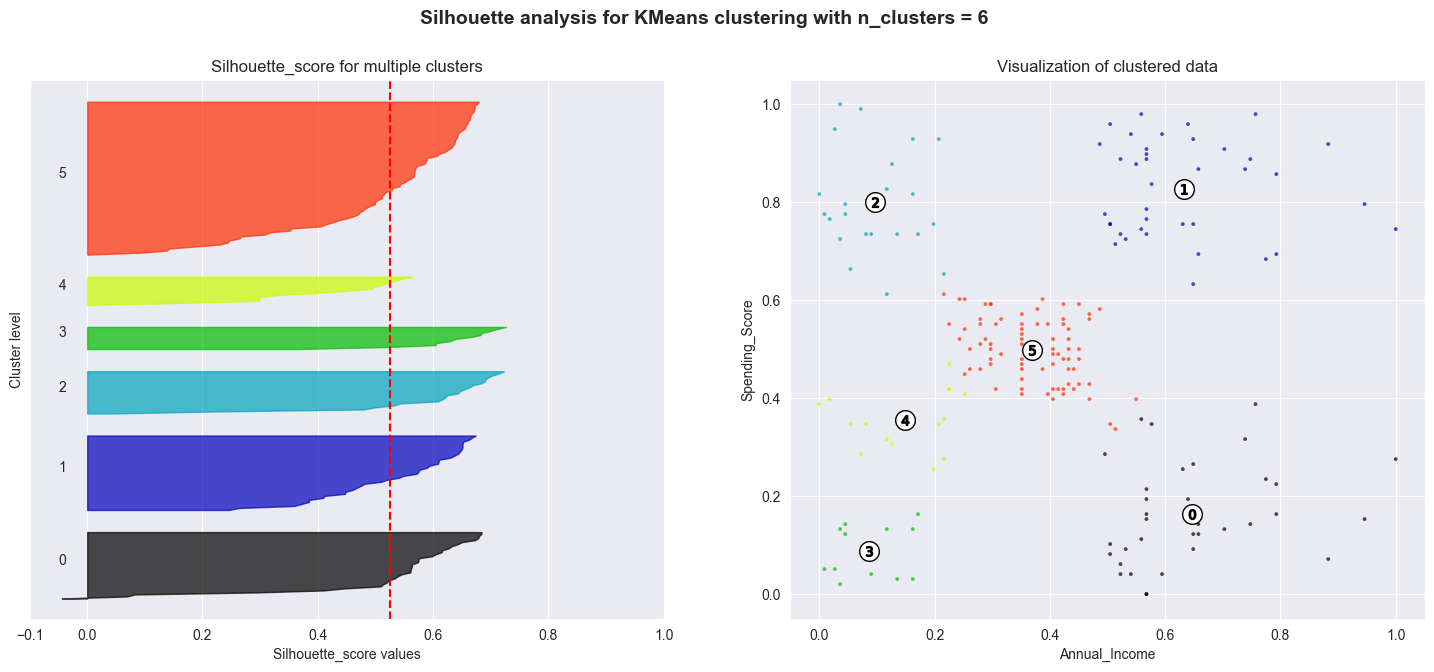

In [23]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    #Create a subplot with 1 row and 2 columns.
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    #The 1st subplot is the silhouette plot.
    #The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1].
    ax1.set_xlim([-0.1, 1])
    #The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, 
    #to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    #Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    #The silhouette_score gives the average value for all the samples.
    #This gives a perspective into the density and separation of the formed clusters.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    #Compute the silhouette scores for each sample.
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        #Aggregate the silhouette scores for samples belonging to cluster i, and sort them.
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        #Label the silhouette plots with their cluster numbers at the middle.
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        #Compute the new y_lower for next plot.
        y_lower = y_upper + 10  #10 for the 0 samples.

    ax1.set_title("Silhouette_score for multiple clusters")
    ax1.set_xlabel("Silhouette_score values")
    ax1.set_ylabel("Cluster level")

    #The vertical line for average silhouette score of all the values.
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  #Clear the yaxis labels / ticks.
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #2nd Plot showing the actual clusters formed.
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    #Labeling the clusters.
    centers = clusterer.cluster_centers_
    #Draw white circles at cluster centers.
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualization of clustered data")
    ax2.set_xlabel("Annual_Income")
    ax2.set_ylabel("Spending_Score")

    plt.suptitle(("Silhouette analysis for KMeans clustering"
                  " with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

##### Finding the hyperparameter K using the Elbow method

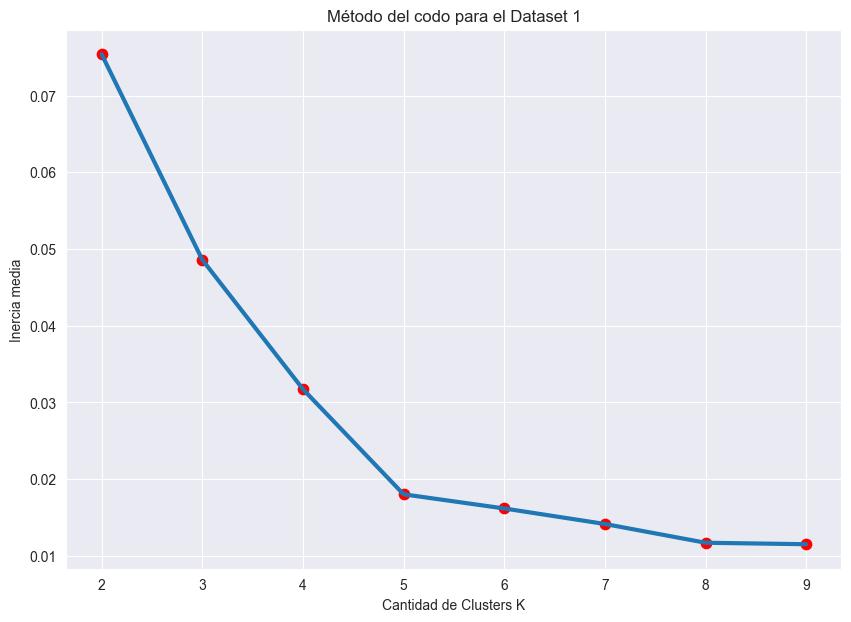

In [24]:

Sum_of_squared_distances = []
K = np.arange(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    distancia_total = km.inertia_
    distancia_media = np.divide(distancia_total,X.shape[0])
    Sum_of_squared_distances.append(distancia_media)
#Grafica de la suma de las distancias
plt.figure(figsize = (10,7))
plt.plot(K, Sum_of_squared_distances, lw=3)
plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para el Dataset 1')

plt.show()

In [25]:
# Choose the number of clusters (k)
k = 5

#Set the hyperparameters.
kmeans = KMeans(n_clusters=k, random_state=42)

#Train with the dataset without outliers and predict with the dataset with outliers.
kmeans.fit(X)


KMeans(n_clusters=5, random_state=42)

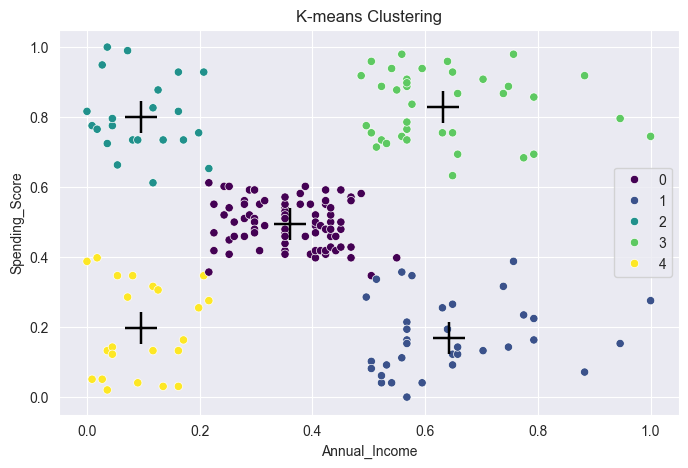

In [28]:
plt.figure(figsize = (8,5))
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

sns.scatterplot(data=df_2, x='Annual_Income', y='Spending_Score', hue=clusters, palette='viridis')
sns.scatterplot(x = centroids[:, 0], y = centroids[:, 1], color='black', marker="+", s=500)
plt.title('K-means Clustering')
plt.xlabel('Annual_Income')
plt.ylabel('Spending_Score')
plt.show()

##### Segmentattion using the DBSCAN algorithm